<a href="https://colab.research.google.com/github/adunStudio/hanghae99_plusAI_2/blob/main/1%EC%A3%BC%EC%B0%A8/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [21]:
# 데이터셋 전처리:
# 1. PIL 이미지 또는 NumPy 배열 → PyTorch Tensor로 변환
# 2. 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
transform = transforms.ToTensor()

# MNIST 학습 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# MNIST 훈련 데이터셋 로드
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


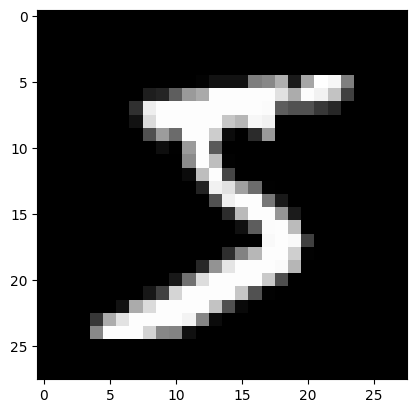

In [22]:
from matplotlib import pyplot as plt

print(len(train_set))
print(train_set[0][0].shape, train_set[0][1])
plt.imshow(train_set[0][0][0], cmap='gray')
# 60,000개의 이미지로 구성되어있다.
# [1, 28, 28]: 1채널(흑백), 28 x 28 크기 이미지

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [47]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [48]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [49]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [50]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, num_dim, num_classes):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, num_dim)
    self.layer2 = nn.Linear(num_dim, num_dim)
    self.layer3 = nn.Linear(num_dim, num_classes)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024, 10)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [51]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [52]:
import time

num_epochs = 100

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  model.eval()  # 평가 모드
  with torch.no_grad():
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 5.82 seconds | Loss: 540.17 | Train Acc: 0.258 | Test Acc: 0.265
Epoch   2 | Time: 5.87 seconds | Loss: 537.66 | Train Acc: 0.361 | Test Acc: 0.375
Epoch   3 | Time: 5.88 seconds | Loss: 534.87 | Train Acc: 0.413 | Test Acc: 0.426
Epoch   4 | Time: 5.81 seconds | Loss: 531.63 | Train Acc: 0.470 | Test Acc: 0.485
Epoch   5 | Time: 5.86 seconds | Loss: 528.36 | Train Acc: 0.502 | Test Acc: 0.518
Epoch   6 | Time: 5.80 seconds | Loss: 524.88 | Train Acc: 0.517 | Test Acc: 0.532
Epoch   7 | Time: 5.86 seconds | Loss: 521.11 | Train Acc: 0.523 | Test Acc: 0.536
Epoch   8 | Time: 5.81 seconds | Loss: 516.95 | Train Acc: 0.527 | Test Acc: 0.539
Epoch   9 | Time: 5.82 seconds | Loss: 512.31 | Train Acc: 0.529 | Test Acc: 0.542
Epoch  10 | Time: 5.81 seconds | Loss: 507.15 | Train Acc: 0.531 | Test Acc: 0.543
Epoch  11 | Time: 5.81 seconds | Loss: 501.38 | Train Acc: 0.534 | Test Acc: 0.547
Epoch  12 | Time: 5.83 seconds | Loss: 494.94 | Train Acc: 0.537 | Test Acc: 0.548
Epoc

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [54]:
idx = 3

x = train_set[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(train_set[idx][1])

tensor([[0.0000, 6.4279, 1.7217, 0.6748, 0.0000, 0.0000, 0.0000, 0.0000, 2.6120,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
1


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

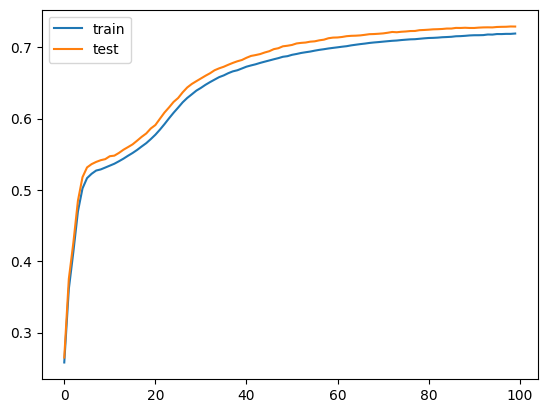

In [55]:
import numpy as np

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accuracies, test_accuracies)